Spinoff new notebooks from this one.

# Initialize Notebook

## Module Imports

In [1]:
################################################
#                    IMPORT                    #
################################################


import math
import random
import pandas as pd
import numpy as np
import itertools as IT

import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


# Classification Models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_formats = ['retina']

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Load Data

In [2]:
################################################
#   aisle, dept, prod indexes, merge prod dir  #
################################################

df_aisle_index = pd.read_csv('../data/instacart-market-basket-analysis/aisles.csv')
# print(df_aisle_index.shape)
df_dept_index = pd.read_csv('../data/instacart-market-basket-analysis/departments.csv')
# print(df_dept_index.shape)
df_prod_index = pd.read_csv('../data/instacart-market-basket-analysis/products.csv')
# print(df_prod_index.shape)

df_prod_dir = pd.merge(df_prod_index, df_dept_index, on='department_id')
df_prod_dir = pd.merge(df_prod_dir, df_aisle_index, on='aisle_id')

print('loaded aisle, dept, and prod indexes, and created merge product directory')


################################################
#  LOAD ORDERS LOG AND PRIOR/TRAIN ORDER-PRODS #
################################################

user_subset = range(1,501, 1)
print('generated user subset of size: ', len(user_subset))

df_orders_log = pd.DataFrame(
    columns=['order_id','user_id','eval_set','order_number',
             'order_dow','order_hour_of_day','days_since_prior_order']
)

# chunk import
def valid_user(chunks):
    for chunk in chunks:
        mask = chunk.user_id.isin(user_subset)
        yield chunk.loc[mask]
    
# read in orders
filename = '../data/instacart-market-basket-analysis/orders.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_orders_log = pd.concat(valid_user(chunks))

print('sample size for ORDERS LOG:')
print(sys.getsizeof(df_orders_log)/1000000,'MB out of total',
      os.stat('../data/instacart-market-basket-analysis/orders.csv').st_size//1000000,'MB')

# compile a list of unique orders that originate from our user sample

orders_subset = df_orders_log.order_id.unique()
print(orders_subset.shape)

def valid_order(chunks):
    for chunk in chunks:
        mask = chunk.order_id.isin(orders_subset)
        yield chunk.loc[mask]
        
df_order_prods__prior = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order','reordered']
)

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__prior.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__prior = pd.concat(valid_order(chunks))

print('sample size for ORDER PROD PRIOR:')
print(sys.getsizeof(df_order_prods__prior)/1000000,'MB out of total',
      os.stat('../data/instacart-market-basket-analysis/order_products__prior.csv').st_size//1000000,'MB')
print(df_order_prods__prior.shape)

df_order_prods__train = pd.DataFrame(
    columns=['order_id','product_id','add_to_cart_order']
)

# read in order_prods_prior
filename = '../data/instacart-market-basket-analysis/order_products__train.csv'
chunksize = 10 ** 4
chunks = pd.read_csv(filename, chunksize=chunksize)
df_order_prods__train = pd.concat(valid_order(chunks))

print('sample size for ORDER PROD TRAIN:')
print(sys.getsizeof(df_order_prods__train)/1000000,'MB out of total',
      os.stat('../data/instacart-market-basket-analysis/order_products__train.csv').st_size//1000000,'MB')
print(df_order_prods__train.shape)

loaded aisle, dept, and prod indexes, and created merge product directory
generated user subset of size:  500
sample size for ORDERS LOG:
0.960604 MB out of total 108 MB
(8142,)
sample size for ORDER PROD PRIOR:
3.097032 MB out of total 577 MB
(77425, 4)
sample size for ORDER PROD TRAIN:
0.135472 MB out of total 24 MB
(3386, 4)


# Problem Description and Ambitions

This notebook proposes a dynamic shopping cart "completer" system for deployment in the Instacart shopping interface. Users with pre-determined shopping intent should receive quality of life improvement when the cart-completer displays the next

The cart-completer panel in this instance offers a limited set of recommendations (~5) in a visible panel.

The model should be...

### 1: Agnostic to the Amount of Data

The model should be able to operate from day one, with limited observations.

### 2: Evolve Strategy as Data Quality Increases

The model will re-train at regular intervals across a stream of orders. Batches of orders represent days, at which point time-intensive re-train can take place.

## "Cart Completer" Model Evaluation Schema

A custom evaluation metric has been calculated for this purpose. The cart-completer only needs one of it's 5-10 alloted recommendation slots to contain the next item.

### Baseline Algorithm: Recommend Products By Global Popularity

As a baseline, let's create a simple algorithm that simply returns a random 5 products from the top 50 most popular products. We hope to do better than this algorithm by engineering all kinds of user- and product-specific features.

In [13]:
## NAIVE MODEL - Product Popularity Focused ##

# code to return top 50 products
# df_order_prods__prior.groupby('product_id').agg(
#     {'order_id':'nunique'}
# ).sort_values('order_id',ascending=False).index.values[:50]

class NaiveTopProducts(object):
    '''
    
    A naive product recommendation algorithm,
    based on overal product popularity.
    
    '''
    
    def __init__(self):
    
        self.type = 'naive'
    
    def fit(self, order_train):
        '''
        
        Pull top 50 products from dataframe.
        
        '''
        
        self.top100 = set(order_train.groupby('product_id').agg(
            {'order_id':'nunique'}
        ).sort_values('order_id',ascending=False).index.values[:100])
        
    def predict(self, n=5):
        
        return random.sample(self.top100, n)

In [14]:
naive_model = NaiveTopProducts()
naive_model.fit(df_order_prods__prior)
preds = naive_model.predict()

### Simulate Dynamic Product Recommendation

In [15]:
def SimulateDynamicRec(order_rows, model, verbose=False):
    
    assert type(order_rows) == type(pd.DataFrame())
    cart = set([])
    
    order_rows = order_rows.sort_values('add_to_cart_order')
    
    if verbose:
        print('testing the following order:\n', order_rows)
    
    total = 0
    guessed = 0
    
    # progress through order one at a time
    for index, row in order_rows.iterrows():
        
        ### Recommend 5 New Products ###
        
        try:
            #### CHECK MODEL TYPE #####
            model_type = model.type
#             print('model type is: ', model_type)
            if model_type in ['naive','reordered']:
                recommendations = model.top100
            
            
            # Exclude items already in cart.
            rec5 = random.sample((recommendations - cart), 5)
            
        except:
            #### OTHER MODELS #####
            pass
        
        
        total += 1
        success = False
        
        actual_next = row['product_id']
        
        if actual_next in rec5:
            success = True
            guessed += 1
        
        # debug output
        if verbose:
#             print(f'Cart is {cart}.\nRecommending {rec5}.')
            if success:
                print(f'Guessed {actual_next}!\n')
                continue
            else:
#                 print(f'Oops, {actual_next} wasn\'t in recommendation list.')
                continue
        
        cart.add(actual_next)
    
    # rel_pct = % of trials where recommendations were relevant to next purchase.
    rel_pct = guessed/total
    
    if verbose:
        print(f'Got {rel_pct}% right of {total}.')
    
    return rel_pct

In [16]:
def DynamicRecScore(model, trials = 100):

    relevancies = []
    
    unique_train_orders = set(df_order_prods__train.order_id.unique())
#     print(len(unique_train_orders))
    
    # If there aren't enough training datapoints.
    if trials > len(unique_train_orders):
        trials = len(unique_train_orders)
    
    for order_id in random.sample(unique_train_orders, trials):
        
#         test_order = df_order_prods__train.sample().order_id.values[0]

        test_order_rows = df_order_prods__train[df_order_prods__train.order_id == order_id]
        rel_pct = SimulateDynamicRec(test_order_rows, model,verbose=False)
        relevancies += [rel_pct]
        
    return np.mean(relevancies)

## Score Naive Top Products Model

Run simulation of user interactive with Naive Top Products as recommender.

In [17]:
# Simple cross validation of naive algorithm:

n_trials = 300
relevancies = []
for i in range(5):
    relevancies += [DynamicRecScore(model=naive_model, trials=n_trials)]
    
print(f'Mean dynamic suggestion relevancy score, Naive Algorithm, n={n_trials}:')
print(np.mean(relevancies))

Mean dynamic suggestion relevancy score, Naive Algorithm, n=300:
0.00937538738659981


# EDA

In [15]:
# Make a complete order-product list from prior and train, keeping all fields:
df_all_order_prods = pd.concat([df_order_prods__prior, df_order_prods__train])
df_all_order_prods = pd.merge(df_all_order_prods, df_prod_dir, on='product_id')
df_all_order_prods = pd.merge(df_all_order_prods, df_orders_log, on='order_id')
df_all_order_prods.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'department', 'aisle',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

Distributions of departments / aisles / products.

In [16]:
print('number of products = ', df_prod_index.shape[0])
print('number of aisles = ', df_aisle_index.shape[0])
print('number of depts = ', df_dept_index.shape[0])

number of products =  49688
number of aisles =  134
number of depts =  21


In [17]:
df_prod_dir = pd.merge(df_prod_index, df_dept_index, on='department_id')
df_prod_dir = pd.merge(df_prod_dir, df_aisle_index, on='aisle_id')

#### How many products _offered_ in each department?

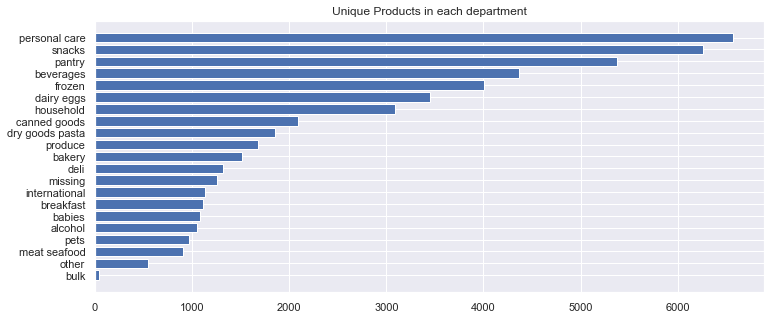

In [58]:
# Use the complete product directory for this:
data = df_prod_dir.groupby('department').product_name.nunique().sort_values()
fig = plt.figure(figsize=(12,5))
plt.barh(y=data.index, width=data.values)
plt.title("Unique Products in each department");

#### Unique Products Offered vs. Unique Products Purchased?

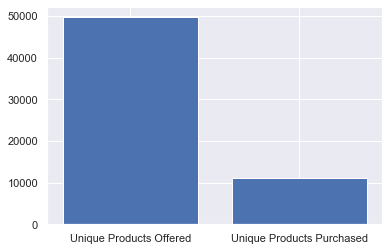

In [68]:
unique_prods_offered = df_prod_dir.product_name.nunique()
unique_prods_purchased = df_all_order_prods.product_name.nunique()

data = ({'Unique Products Offered':df_prod_dir.product_name.nunique(),
         'Unique Products Purchased': df_all_order_prods.product_name.nunique()})
plt.bar(data.keys(), list(data.values()));

#### How many Unique Products / User vs Products / User?


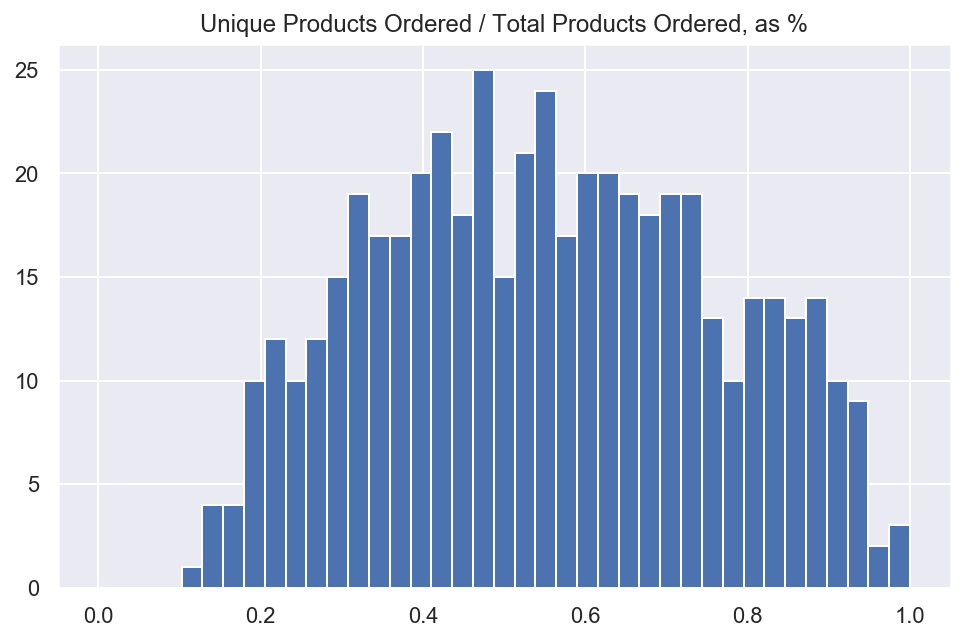

In [141]:
user_prods_nunique = df_all_order_prods.groupby(by='user_id').product_name.nunique()
user_order_prods_counts = df_all_order_prods.groupby(by=['user_id']).count()['product_id']
user_prod_reorder_pct = user_prods_nunique / user_order_prods_counts
data = np.digitize(user_prod_reorder_pct, np.linspace(0, 1, 10))

fig, ax = plt.subplots(figsize=(8,5))

plt.title('Unique Products Ordered / Total Products Ordered, as %')
plt.hist(user_prod_reorder_pct, bins=np.linspace(0, 1, 40));


#### For any given user-product combination, what percentage of future orders include re-orders of that product?

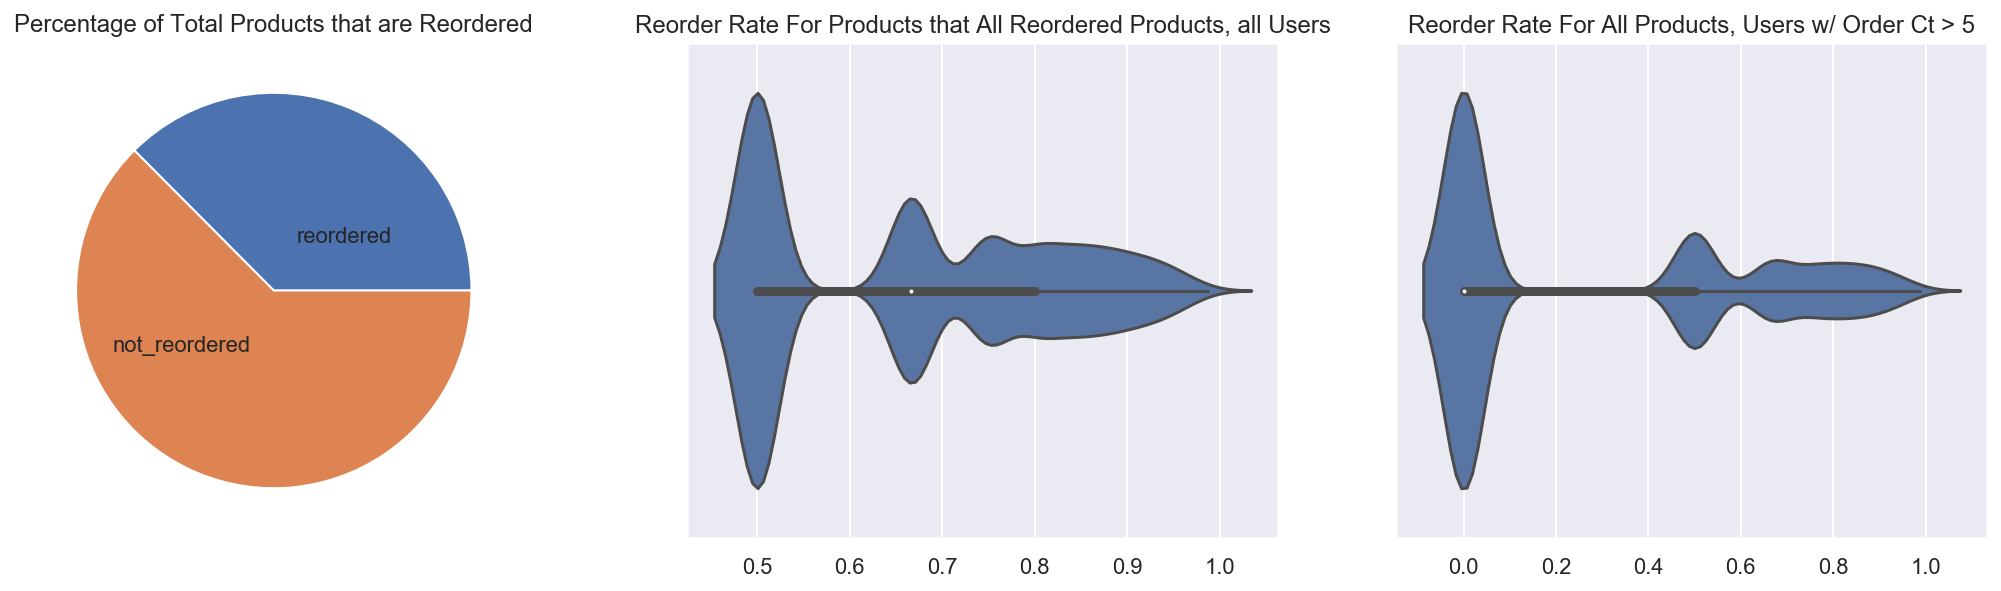

In [311]:
reorder_rates = (df_all_order_prods.groupby(['user_id','product_id'])['reordered'].sum()
                 / df_all_order_prods.groupby(['user_id','product_id'])['order_id'].nunique())

fig, axes = plt.subplots(figsize=(18,10))

ax = plt.subplot(2,3,1)
not_reordered_ct = len(reorder_rates[reorder_rates.values == 0])
plt.pie(x=[not_reordered_ct, len(reorder_rates)], labels=['reordered', 'not_reordered'], labeldistance=0.3)

plt.title("Percentage of Total Products that are Reordered");

ax = plt.subplot(2,3,2)
plt.title("Reorder Rate For Products that All Reordered Products, all Users")

sns.violinplot(reorder_rates[reorder_rates.values > 0]);

ax = plt.subplot(2,3,3)

plt.title("Reorder Rate For All Products, Users w/ Order Ct > 5")
reorder_rates_multi_order_users = (
    df_all_order_prods[df_all_order_prods.user_id.isin(multi_order_users)]
    .groupby(['user_id','product_id']).agg({'reordered':'sum'})['reordered'].values
    / df_all_order_prods[df_all_order_prods.user_id.isin(multi_order_users)]
    .groupby(['user_id','product_id'])['order_id'].nunique().values
)

sns.violinplot(reorder_rates_multi_order_users);

# ax = plt.subplot(2,3,4)

#### Product Popularity

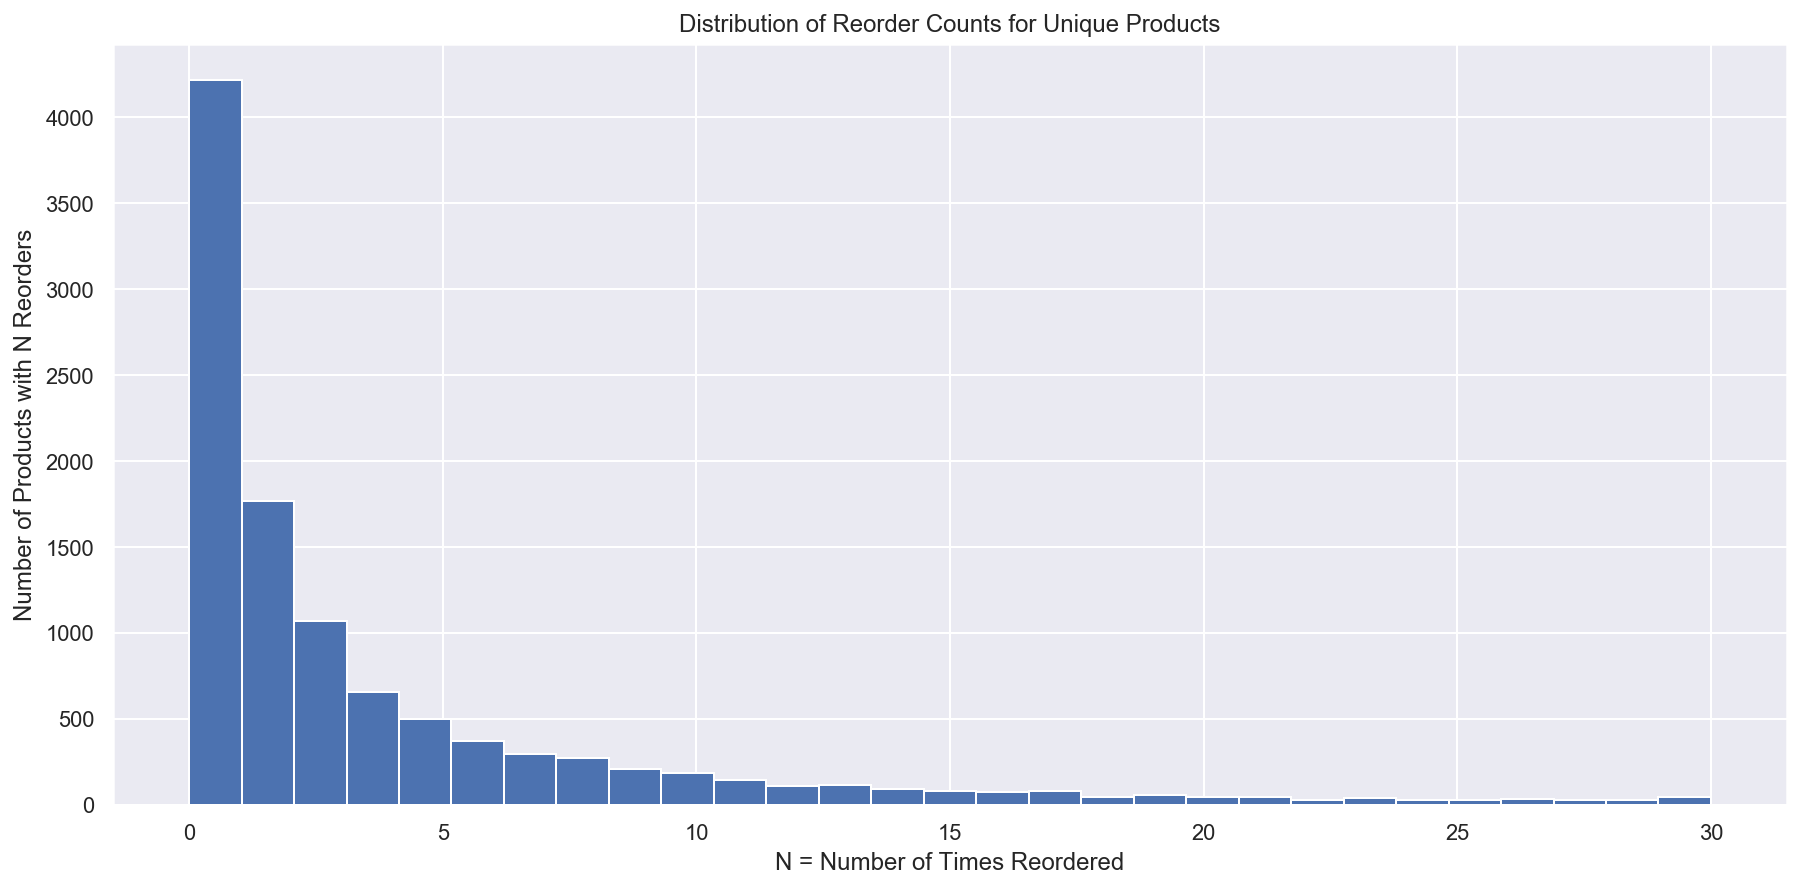

In [328]:
data = {'prod_unique_orders': df_all_order_prods.groupby(by='product_id').agg({'order_id':'nunique'}).values}

fig, ax = plt.subplots(figsize=(15,7))

plt.hist(x='prod_unique_orders',bins=np.linspace(0,30,30), data=data, log=False)

plt.xlabel("N = Number of Times Reordered")
plt.ylabel("Number of Products with N Reorders")

plt.title("Distribution of Reorder Counts for Unique Products");

#### Product Reorders by Department

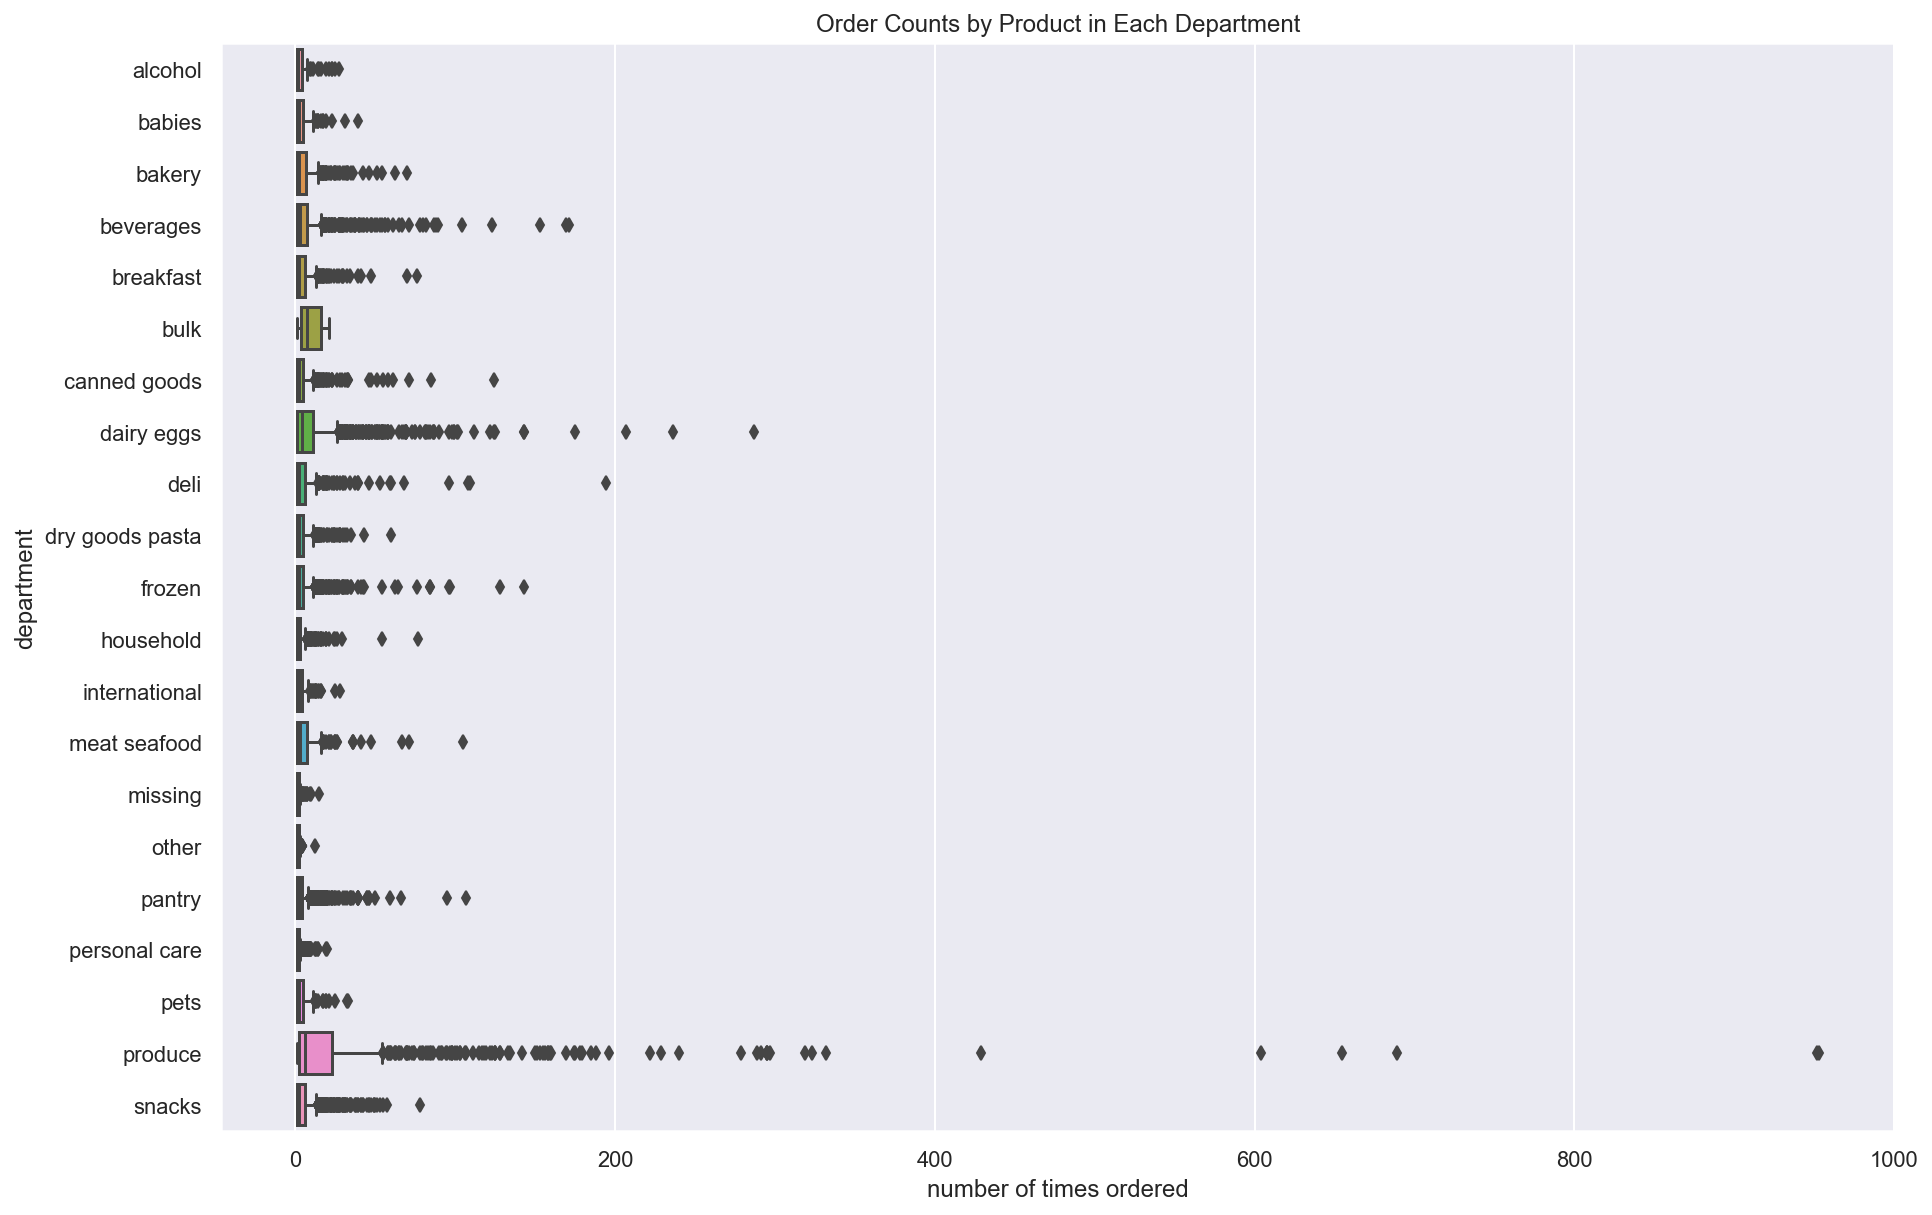

In [15]:
data = df_all_order_prods.groupby(by=['department','product_id']).agg({'order_id':'nunique'}).reset_index()

x_cat = data.department
y_val = data.order_id

fig, ax = plt.subplots(figsize=(15,10))



sns.boxplot(y=x_cat, x=y_val, orient='h', )
plt.title("Order Counts by Product in Each Department")
plt.xlabel('number of times ordered');

In [16]:
for dept in df_dept_index.values:
    
    data.loc[dept]

    prod_orders = data.values
    
    fig, ax = plt.subplots(figsize=(15,10))

    plt.(x=prod_orders, linestyle=)
    plt.title("Order Counts by Product in Each Department")
    plt.xlabel('number of times ordered');

SyntaxError: invalid syntax (<ipython-input-16-2f6071506ca1>, line 9)

## EDA – Orders

In [268]:
df_orders_log.head(3)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0

## EDA - Order Products

### Prior

In [265]:
print(df_order_prods__prior.shape)
df_order_prods__prior.head(3)

(77425, 4)


order_id  product_id  add_to_cart_order  reordered
333        40       10070                  1          1
334        40       42450                  2          1
335        40       33198                  3          1

In [264]:
# inspect an individual order from prior
df_order_prods__prior[df_order_prods__prior.order_id == 1483].head(3)

order_id  product_id  add_to_cart_order  reordered
14111      1483       32818                  1          1
14112      1483       27582                  2          1
14113      1483       12302                  3          1

### Train

In [387]:
print(df_order_prods__train.shape)
df_order_prods__train.head(1)

(3386, 4)


order_id  product_id  add_to_cart_order  reordered
239       988       45061                  1          0

In [388]:
# inspect an individual order from train
df_order_prods__train[df_order_prods__train.order_id == 988]

order_id  product_id  add_to_cart_order  reordered
239       988       45061                  1          0
240       988       28464                  2          0
241       988       12626                  3          0
242       988        4818                  4          1

# Merge, Append Aisle/Department Columns to Order Log

In [3]:
df_order_prods__prior = pd.merge(
    df_order_prods__prior,
    df_prod_index, on='product_id')

# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__prior = df_order_prods__prior[['order_id','product_id','product_name','add_to_cart_order','reordered','aisle_id','department_id']]

df_order_prods__train = pd.merge(
    df_order_prods__train,
    df_prod_index, on='product_id')

# Confirm we haven't merged in duplicate columns from re-running this script.
df_order_prods__train = df_order_prods__train[['order_id','product_id','product_name','add_to_cart_order','reordered','aisle_id','department_id']]


df_order_prods__prior.head()

order_id  product_id             product_name  add_to_cart_order  \
0        40       10070  Organic 1% Low Fat Milk                  1   
1    116744       10070  Organic 1% Low Fat Milk                  3   
2    120295       10070  Organic 1% Low Fat Milk                  2   
3    247775       10070  Organic 1% Low Fat Milk                  2   
4    405284       10070  Organic 1% Low Fat Milk                  1   

   reordered  aisle_id  department_id  
0          1        84             16  
1          1        84             16  
2          1        84             16  
3          1        84             16  
4          1        84             16

# Identify User-Product Combinations Suitable as Classifier Targets

We will use a list of the user's previously ordered products as a list of candidate products for the model to classify as "reorder" or "not reorder."

## Create `df_user_prod_candidates` Dataframe
Includes all poss. User-Product Combinations, from `__prior`

In [4]:
df_order_prods__prior = pd.merge(df_order_prods__prior, df_orders_log, on='order_id')
df_order_prods__prior.head()

order_id  product_id                     product_name  add_to_cart_order  \
0        40       10070          Organic 1% Low Fat Milk                  1   
1        40       42450                Macaroni & Cheese                  2   
2        40       33198  Sparkling Natural Mineral Water                  3   
3        40       34866        Chocolate Milk 1% Milkfat                  4   
4    116744       10070          Organic 1% Low Fat Milk                  3   

   reordered  aisle_id  department_id  user_id eval_set  order_number  \
0          1        84             16      382    prior            29   
1          1        38              1      382    prior            29   
2          1       115              7      382    prior            29   
3          1        84             16      382    prior            29   
4          1        84             16      382    prior            23   

   order_dow  order_hour_of_day  days_since_prior_order  
0          1                 15                    23.0  
1          1                 15                    23.0  
2          1                 15                    23.0  
3          1                 15                    23.0  
4          4                 17                     8.0

In [5]:
# We will use a list of previously ordered products as a good candidate set to predict
# the contents of the most recent cart. For each product, we will classify the candidate
# as reorder = 1 or 0.

df_user_prod_cands = df_order_prods__prior.groupby('user_id').agg({'product_id':'unique'})

df_user_prod_cands = df_user_prod_cands.product_id.apply(pd.Series).stack().reset_index()
df_user_prod_cands = df_user_prod_cands.drop(labels='level_1', axis=1)
df_user_prod_cands = df_user_prod_cands.rename(columns={0:'product_id'})

# fix float output of prod id
df_user_prod_cands.product_id = df_user_prod_cands.product_id.astype(int)

df_user_prod_cands

user_id  product_id
0            1       13176
1            1       41787
2            1         196
3            1       12427
4            1       25133
...        ...         ...
32228      500       48071
32229      500       23819
32230      500        4674
32231      500        3526
32232      500       20919

[32233 rows x 2 columns]

In [6]:
# For each user_id, add new rows representing all of the possible orders for each user_id.
# For each user-order combination, we will classify all previously ordered products as reordered, or not.

# We will first need a list of unique user-order_id's from the order_prods__train set.

df_user_order_prods_train = pd.merge(
    df_orders_log[['user_id', 'order_id']],
    df_order_prods__train[['order_id','product_id']],
    on='order_id',
    how='right'
)
df_user_order_prods_train

user_id  order_id  product_id
0           1   1187899       27845
1           1   1187899       49235
2           1   1187899       38928
3           1   1187899         196
4           1   1187899       25133
...       ...       ...         ...
3381      499    188500       48716
3382      499    188500       44882
3383      499    188500       46027
3384      499    188500        2298
3385      499    188500       23801

[3386 rows x 3 columns]

In [9]:
# How many orders are we looking at in __train?

df_user_order_prods_train[['user_id','order_id']].drop_duplicates().shape

(316, 2)

In [8]:
# How many orders/user are we looking at in __train?

df_user_order_prods_train[['user_id','order_id']].drop_duplicates().groupby('user_id').count().describe()

order_id
count     316.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0

For the subset of 500 users we are looking at, only 316 have an order represented in `__train`. All users with orders in `__train` have only 1 order.

In [10]:
df_user_prod_order_cands = (
    pd.merge(df_user_prod_cands,
             df_user_order_prods_train,
             on=['user_id','product_id'],
             how='outer'
)
)
print('nulls:', df_user_prod_order_cands[df_user_prod_order_cands.isnull().any(axis=1)].shape[0])
print('total:', df_user_prod_order_cands.shape[0])

nulls: 30134
total: 33520


In [11]:
df_user_prod_order_cands['reordered'] = (df_user_prod_order_cands['order_id']
                                         .apply(lambda x: 0 if np.isnan(x) else 1))
df_user_prod_order_cands

user_id  product_id   order_id  reordered
0            1       13176        NaN          0
1            1       41787        NaN          0
2            1         196  1187899.0          1
3            1       12427        NaN          0
4            1       25133  1187899.0          1
...        ...         ...        ...        ...
33515      499       35902   188500.0          1
33516      499       40199   188500.0          1
33517      499       44882   188500.0          1
33518      499        2298   188500.0          1
33519      499       23801   188500.0          1

[33520 rows x 4 columns]

In [12]:
print('percent of previous products that were reordered:')
print(df_user_prod_order_cands.reordered.sum() / df_user_prod_order_cands.shape[0])

percent of previous products that were reordered:
0.1010143198090692


In [13]:
df_Xy = df_user_prod_order_cands

In [14]:
df_Xy = df_Xy.rename(columns = {'order_id':'reordered_in_order_id'})

In [15]:
df_Xy.sample(10)

user_id  product_id  reordered_in_order_id  reordered
27001      419       17530              1449813.0          1
21573      327       22000                    NaN          0
5340        90       42356                    NaN          0
19227      294       28842                    NaN          0
19850      306       16283                    NaN          0
18762      290        4505                    NaN          0
4784        79       22035                    NaN          0
23118      355       35108                    NaN          0
32732      205        3376              2177938.0          1
9151       152       28289                    NaN          0

# User Profiles

## Initialize User Dataframe

In [16]:
# Create a users database with some historical information for each user
df_user_profs = pd.DataFrame()
df_user_profs['user_id'] = user_subset

def get_user_orders(user_id, df_orders_log):
    '''
    
    Return an ordered list of tuples,
    e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
    '''
    
    user_orders = df_orders_log[df_orders_log.user_id == user_id]
    
    return (user_orders[['order_number', 'order_id']]).to_numpy() 

In [17]:
df_user_profs['order_id_history'] = df_user_profs.user_id.apply(
    get_user_orders, df_orders_log=df_orders_log
)
df_user_profs.head(1)

user_id                                   order_id_history
0        1  [[1, 2539329], [2, 2398795], [3, 473747], [4, ...

### Unique Order Count (User)

In [18]:
df_user_profs['num_orders'] = df_user_profs.order_id_history.apply(lambda x: len(x))
df_user_profs.head(2)

user_id                                   order_id_history  num_orders
0        1  [[1, 2539329], [2, 2398795], [3, 473747], [4, ...          11
1        2  [[1, 2168274], [2, 1501582], [3, 1901567], [4,...          15

### Order Sizes (User)

In [19]:
user_order_sizes = (df_order_prods__prior.groupby(['user_id', 'order_id'])['product_id']
                  .nunique().reset_index()
                  .rename(columns={'product_id':'order_size'})
                 )
user_order_sizes.head(3)

user_id  order_id  order_size
0        1    431534           8
1        1    473747           5
2        1    550135           5

In [20]:
user_order_sizes.groupby('user_id').order_size.mean().reset_index()

user_id  order_size
0          1    5.900000
1          2   13.928571
2          3    7.333333
3          4    3.600000
4          5    9.250000
..       ...         ...
495      496    5.512195
496      497   17.777778
497      498   11.166667
498      499    9.833333
499      500   12.666667

[500 rows x 2 columns]

In [21]:
df_Xy = pd.merge(df_Xy,
                 user_order_sizes.groupby('user_id').order_size.mean().reset_index(),
                 on='user_id').rename(columns={'order_size':'avg_order_size'})
df_Xy

user_id  product_id  reordered_in_order_id  reordered  avg_order_size
0            1       13176                    NaN          0        5.900000
1            1       41787                    NaN          0        5.900000
2            1         196              1187899.0          1        5.900000
3            1       12427                    NaN          0        5.900000
4            1       25133              1187899.0          1        5.900000
...        ...         ...                    ...        ...             ...
33515      500       48071                    NaN          0       12.666667
33516      500       23819                    NaN          0       12.666667
33517      500        4674                    NaN          0       12.666667
33518      500        3526                    NaN          0       12.666667
33519      500       20919                    NaN          0       12.666667

[33520 rows x 5 columns]

In [22]:
## Average Order Sizes by User ##

def avg_user_order_sizes(order_id_history, df_order_prods):
    
    order_id_list = order_id_history[:,1]

    avg_order_size = (
        df_order_prods[df_order_prods.order_id.isin(order_id_list)]              
        .groupby('order_id')
        .agg('nunique')
    ).mean()['product_id']

#     print(avg_order_size)
    return avg_order_size


df_user_profs['avg_order_size'] = (df_user_profs.order_id_history
                                    .apply(avg_user_order_sizes, df_order_prods=df_order_prods__prior)
                                   )

df_user_profs.sample(2)

user_id                                   order_id_history  num_orders  \
93        94  [[1, 1836789], [2, 3274946], [3, 2758592], [4,...          10   
465      466  [[1, 1534056], [2, 230890], [3, 2808529], [4, ...          32   

     avg_order_size  
93         6.222222  
465       22.129032

In [23]:
# Create a dictionary of unique orders for the same product, by user.
def get_user_product_counts(user_id, df_order_prods__prior, df_prod_dir):
    
    '''
    
    Return an ordered list of tuples,
    e.g. [(1, order_id_1), ... , (latest_order_number, latest_order_id)]
    
    '''
    
    user_prods = (df_order_prods__prior
                  .groupby(by=['user_id','product_id'])['order_id']
                  .nunique().loc[user_id]
                 )
    
    user_prods = (
        pd.merge(user_prods,
                 df_prod_index.drop(labels='product_name', axis=1),
                 on='product_id').rename(columns={'order_id':'order_ct'})
    ).set_index('product_id').to_dict(orient='index')
    
    return user_prods

df_user_profs['product_counts'] = df_user_profs.user_id.apply(
    get_user_product_counts, df_order_prods__prior = df_order_prods__prior, df_prod_dir = df_prod_dir
)

print('sample row of user-prod order counts')
df_user_profs.product_counts.sample(1)

sample row of user-prod order counts


332    {79: {'order_ct': 4, 'aisle_id': 95, 'departme...
Name: product_counts, dtype: object

In [24]:
df_user_profs.sample(1)

user_id                                   order_id_history  num_orders  \
87       88  [[1, 1895573], [2, 1506478], [3, 1963964], [4,...           8   

    avg_order_size                                     product_counts  
87        1.571429  {6104: {'order_ct': 1, 'aisle_id': 120, 'depar...

### Merge user-count(product) information into `df_prod_candidates` dataframe.

In [25]:
user_prod_order_cts = (df_order_prods__prior.groupby(['user_id', 'product_id'])['order_id']
                  .nunique().reset_index()
                  .rename(columns={'order_id':'prev_order_ct'})
                 )

In [26]:
df_Xy = pd.merge(df_Xy, user_prod_order_cts, on=['user_id','product_id'])

### Departmental Unique Check-ins Dictionary (User)

In [27]:
df_Xy = pd.merge(df_Xy, df_prod_index.drop(labels='product_name',axis=1), on='product_id')

In [28]:
df_Xy.head(1)

user_id  product_id  reordered_in_order_id  reordered  avg_order_size  \
0        1       13176                    NaN          0             5.9   

   prev_order_ct  aisle_id  department_id  
0              2        24              4

In [29]:
user_dept_visits = (df_order_prods__prior.groupby(['user_id', 'department_id'])['order_id']
                  .nunique().reset_index()
                  .rename(columns={'order_id':'dept_visits'})
                 )

In [30]:
df_Xy = pd.merge(df_Xy, user_dept_visits, on=['user_id','department_id'])
df_Xy.head(1)

user_id  product_id  reordered_in_order_id  reordered  avg_order_size  \
0        1       13176                    NaN          0             5.9   

   prev_order_ct  aisle_id  department_id  dept_visits  
0              2        24              4            2

## Aisle Check-ins

In [31]:
user_aisle_visits = (df_order_prods__prior.groupby(['user_id', 'aisle_id'])['order_id']
                  .nunique().reset_index()
                  .rename(columns={'order_id':'aisle_visits'})
                 )
user_aisle_visits.head(2)

user_id  aisle_id  aisle_visits
0        1        21             8
1        1        23            10

In [32]:
df_Xy = pd.merge(df_Xy, user_aisle_visits, on=['user_id','aisle_id'])
df_Xy.head(1)

user_id  product_id  reordered_in_order_id  reordered  avg_order_size  \
0        1       13176                    NaN          0             5.9   

   prev_order_ct  aisle_id  department_id  dept_visits  aisle_visits  
0              2        24              4            2             2

In [36]:
# Create a dictionary with department IDs as keys
# each value is the number of unique department check-ins.
# i.e. An order with two products from the same department
# should count as 1 unique check-in.

user_hist = pd.DataFrame()

user_hist['dept_dict'] = dict(zip(df_dept_index.department_id.values,0*df_dept_index.department_id.values))

In [37]:
def unique_dept_checkins(user_id, orders, order_prods, subset='prior'):
    
    user_orders = orders[(orders.user_id == user_id) & (orders.eval_set == subset)]
    
    gb_order = user_orders.groupby('order_id')
    
    
    
    for group in gb_order:
        
        
    
    
    return order_sizes


user_hist['prior_order_sizes'] = pd.Series(user_hist.index.values).apply(
    order_sizes,
    orders=orders,
    order_prods=all_order_prods
)

IndentationError: expected an indented block (<ipython-input-37-0f21c6a027c9>, line 14)

# Department Profiles

In [38]:
# Create a department profile dataframe

df_dept_profs = pd.DataFrame()
df_dept_profs['department_id'] = df_dept_index.department_id

In [39]:
df_dept_profs.head(2)

department_id
0              1
1              2

### Orders / Department

In [42]:
# Calculate number of orders in each department.
dept_nunique = df_order_prods__prior.groupby('department_id').nunique()['order_id'].reset_index()
dept_nunique.rename(columns={'order_id':'num_orders'}, inplace=True)

df_dept_profs = pd.merge(df_dept_profs, dept_nunique, on='department_id')
df_dept_profs.head(3)
# df_user_profs.set_index('user_id', inplace=True)

department_id  num_orders
0              1        2663
1              2          77
2              3        1903

# Aisle Profiles

# User-Product Profiles

In [43]:
## Average Day of Week for user-product combinations

## Average Time of Day for user-product combinations

In [45]:
# Average time of day a product is ordered

_ = (df_order_prods__prior
     .groupby(by=['user_id', 'product_id'])
     .agg({'order_hour_of_day':['mean','var']})
     .reset_index().fillna(99)
    )

_.columns = ['user_id', 'product_id', 'prod_hod_mean', 'prod_hod_var' ]

df_Xy = pd.merge(df_Xy, _, on = ['user_id','product_id'])

## Get Latest Order TOD / Weekday for latest user

In [47]:
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32233 entries, 0 to 32232
Data columns (total 12 columns):
user_id                  32233 non-null int64
product_id               32233 non-null int64
reordered_in_order_id    2099 non-null float64
reordered                32233 non-null int64
avg_order_size           32233 non-null float64
prev_order_ct            32233 non-null int64
aisle_id                 32233 non-null int64
department_id            32233 non-null int64
dept_visits              32233 non-null int64
aisle_visits             32233 non-null int64
prod_hod_mean            32233 non-null float64
prod_hod_var             32233 non-null float64
dtypes: float64(4), int64(8)
memory usage: 3.2 MB


In [48]:
# backfill order_id to all other user-product candidates, to all order time data to be merged in
df_Xy = df_Xy.sort_values(['user_id','reordered_in_order_id']).fillna(method='ffill')

In [49]:
df_Xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32233 entries, 4264 to 32220
Data columns (total 12 columns):
user_id                  32233 non-null int64
product_id               32233 non-null int64
reordered_in_order_id    32233 non-null float64
reordered                32233 non-null int64
avg_order_size           32233 non-null float64
prev_order_ct            32233 non-null int64
aisle_id                 32233 non-null int64
department_id            32233 non-null int64
dept_visits              32233 non-null int64
aisle_visits             32233 non-null int64
prod_hod_mean            32233 non-null float64
prod_hod_var             32233 non-null float64
dtypes: float64(4), int64(8)
memory usage: 4.4 MB


To get meaningful interactions we will also want the actual tod the cart is opened for __train

In [50]:
df_Xy = pd.merge(df_Xy, df_orders_log.drop(labels = ['user_id', 'eval_set'], axis=1),
         left_on = 'reordered_in_order_id', right_on='order_id', how='left'
        ).drop(labels = ['order_id'], axis=1)

In [51]:
df_Xy.columns

Index(['user_id', 'product_id', 'reordered_in_order_id', 'reordered',
       'avg_order_size', 'prev_order_ct', 'aisle_id', 'department_id',
       'dept_visits', 'aisle_visits', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order'],
      dtype='object')

In [52]:
# interaction columns between prod_hod_mean and order_hour_of_day
# add an additional column that divides this column by the prod_hod_var

# df_Xy['prod_hod_var'] = df_Xy['prod_hod_var'].apply(lambda x: -99 if x==0 else x).sample(40).fillna(-99)
df_Xy['prod_hod_delta'] = df_Xy['prod_hod_mean'] - df_Xy['order_hour_of_day']
df_Xy['prod_hod_delta_w'] = (df_Xy['prod_hod_delta'] / df_Xy['prod_hod_var']).fillna(-99).apply(lambda x: -99 if abs(x) > 24 else x)

In [53]:
df_Xy.describe()

user_id    product_id  reordered_in_order_id     reordered  \
count  32233.000000  32233.000000           3.223300e+04  32233.000000   
mean     253.603729  25498.784258           1.792499e+06      0.065120   
std      141.904588  14264.425082           9.585514e+05      0.246741   
min        1.000000      1.000000           9.880000e+02      0.000000   
25%      140.000000  13212.000000           1.094988e+06      0.000000   
50%      251.000000  25551.000000           1.750084e+06      0.000000   
75%      373.000000  38067.000000           2.615515e+06      0.000000   
max      500.000000  49683.000000           3.412247e+06      1.000000   

       avg_order_size  prev_order_ct      aisle_id  department_id  \
count    32233.000000   32233.000000  32233.000000   32233.000000   
mean        12.969321       2.402041     70.947445      10.332392   
std          6.764531       3.457158     38.005193       6.208423   
min          1.000000       1.000000      1.000000       1.000000   
25%          8.173913       1.000000     32.000000       4.000000   
50%         11.722222       1.000000     81.000000      11.000000   
75%         15.705882       2.000000    105.000000      16.000000   
max         39.600000      79.000000    134.000000      21.000000   

        dept_visits  aisle_visits  prod_hod_mean  prod_hod_var  order_number  \
count  32233.000000  32233.000000   32233.000000  32233.000000  32233.000000   
mean      14.907331      8.262588      13.554685     65.632707     24.145348   
std       15.584841     11.031515       3.785065     43.246243     21.425337   
min        1.000000      1.000000       0.000000      0.000000      4.000000   
25%        4.000000      2.000000      11.000000     12.500000      9.000000   
50%        9.000000      4.000000      13.500000     99.000000     17.000000   
75%       19.000000     10.000000      16.000000     99.000000     32.000000   
max       97.000000     92.000000      23.000000    264.500000    100.000000   

          order_dow  order_hour_of_day  days_since_prior_order  \
count  32233.000000       32233.000000            32233.000000   
mean       2.995377          13.422828               14.612354   
std        2.181970           4.387943                9.662866   
min        0.000000           0.000000                0.000000   
25%        1.000000          11.000000                7.000000   
50%        3.000000          13.000000               13.000000   
75%        5.000000          16.000000               22.000000   
max        6.000000          23.000000               30.000000   

       prod_hod_delta  prod_hod_delta_w  
count    32233.000000      32233.000000  
mean         0.131857         -2.063237  
std          5.505266         14.422359  
min        -22.000000        -99.000000  
25%         -3.000000         -0.060606  
50%          0.000000          0.000000  
75%          3.800000          0.070707  
max         23.000000         24.000000

# AWS / SQL Stuff

In [ ]:
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

params = {
    'host': '18.220.115.81',
    'user': 'ubuntu',
    'port': 5432
    
# Connect and create database, disconnect, and reconnect to the right database
connection = connect(**params, dbname='ubuntu')
connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
connection.cursor().execute('CREATE DATABASE store;')
connection.close()

# Modeling & Tests

Model Runs and logs.

In [55]:
#################################

### Modeling Helper Functions ###

#################################


# Our target variable will stay constant – `just_reordered`.

target = ['just_reordered']

def train_val_test_split(df, features, target, train_and_val=True):
    '''
    
    default:
    returns X_train, X_val, y_train, y_val
    
    if train_and_val==False:
    returns X_train, X_val, X_test, y_train, y_val, y_test
    
    '''
    
    
    X = df[features]
    y = df[target]
    
    X, X_test, y, y_ = train_test_split(X, y, test_size=0.2, random_state=4444)
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    
    if train_and_val:
        return X_train, X_val, y_train, y_val
    else:
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    
class BaselineModel(object):
    
#     def __class__(self):
#         return "Baseline"
    
    def __init__(self):
        return None
    
    def fit(self, X_train, y_train):
#         self.C = pd.DataFrame(y_train).mode()
        self.C = 1
    
    def predict(self, X_val):
        return np.full(X_val.shape[0], self.C)
    

def CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=False):
    
    y_val = np.ravel(y_val)
    y_train = np.ravel(y_train)
    
    print(f"Testing {len(estimators)} Models Against Baseline")
    print('features:')
    print(list(X_train.columns))
    print(f".............................................")
    print('')
    
    if print_baseline == True:
        estimators = [['BASELINE', BaselineModel()]] + estimators
        
    for est in estimators:
        name = est[0]
        est = est[1]
        print("__________", name, "__________")
        est.fit(X_train, y_train)
        

        
        pred_train = est.predict(X_train)
        acc = accuracy_score(y_train, pred_train)
        f1 = f1_score(y_train, pred_train)
        roc = roc_auc_score(y_train, pred_train)
        prec = precision_score(y_train, pred_train)
        print(f'Train Set precision={prec} and f1={f1}')
        
        pred_val = est.predict(X_val)
        acc = accuracy_score(y_val, pred_val)
        f1 = f1_score(y_val, pred_val)
        roc = roc_auc_score(y_val, pred_val)
        prec = precision_score(y_val, pred_val)
        print(f'Validation Set precision={prec} and f1={f1}')
        print('-------')
        print('')
    
    return None

In [460]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id', 'aisle_id', 'department_id']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
    ['RF with 100 est, depth 2', RandomForestClassifier(n_estimators=100, max_depth=2)],
    ['RF with 200 est, depth 2', RandomForestClassifier(n_estimators=200, max_depth=2)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 2 Models Against Baseline
features:
['user_id', 'product_id', 'aisle_id', 'department_id']
.............................................

__________ BASELINE __________
Train Set precision=0.0648430632400848
Validation Set precision=0.06452613618737398
-------

__________ RF with 100 est, depth 2 __________
Train Set precision=0.75
Validation Set precision=0.0
-------

__________ RF with 200 est, depth 2 __________
Train Set precision=0.8333333333333334
Validation Set precision=0.0
-------



In [54]:
df_Xy.columns

Index(['user_id', 'product_id', 'reordered_in_order_id', 'reordered',
       'avg_order_size', 'prev_order_ct', 'aisle_id', 'department_id',
       'dept_visits', 'aisle_visits', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w'],
      dtype='object')

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


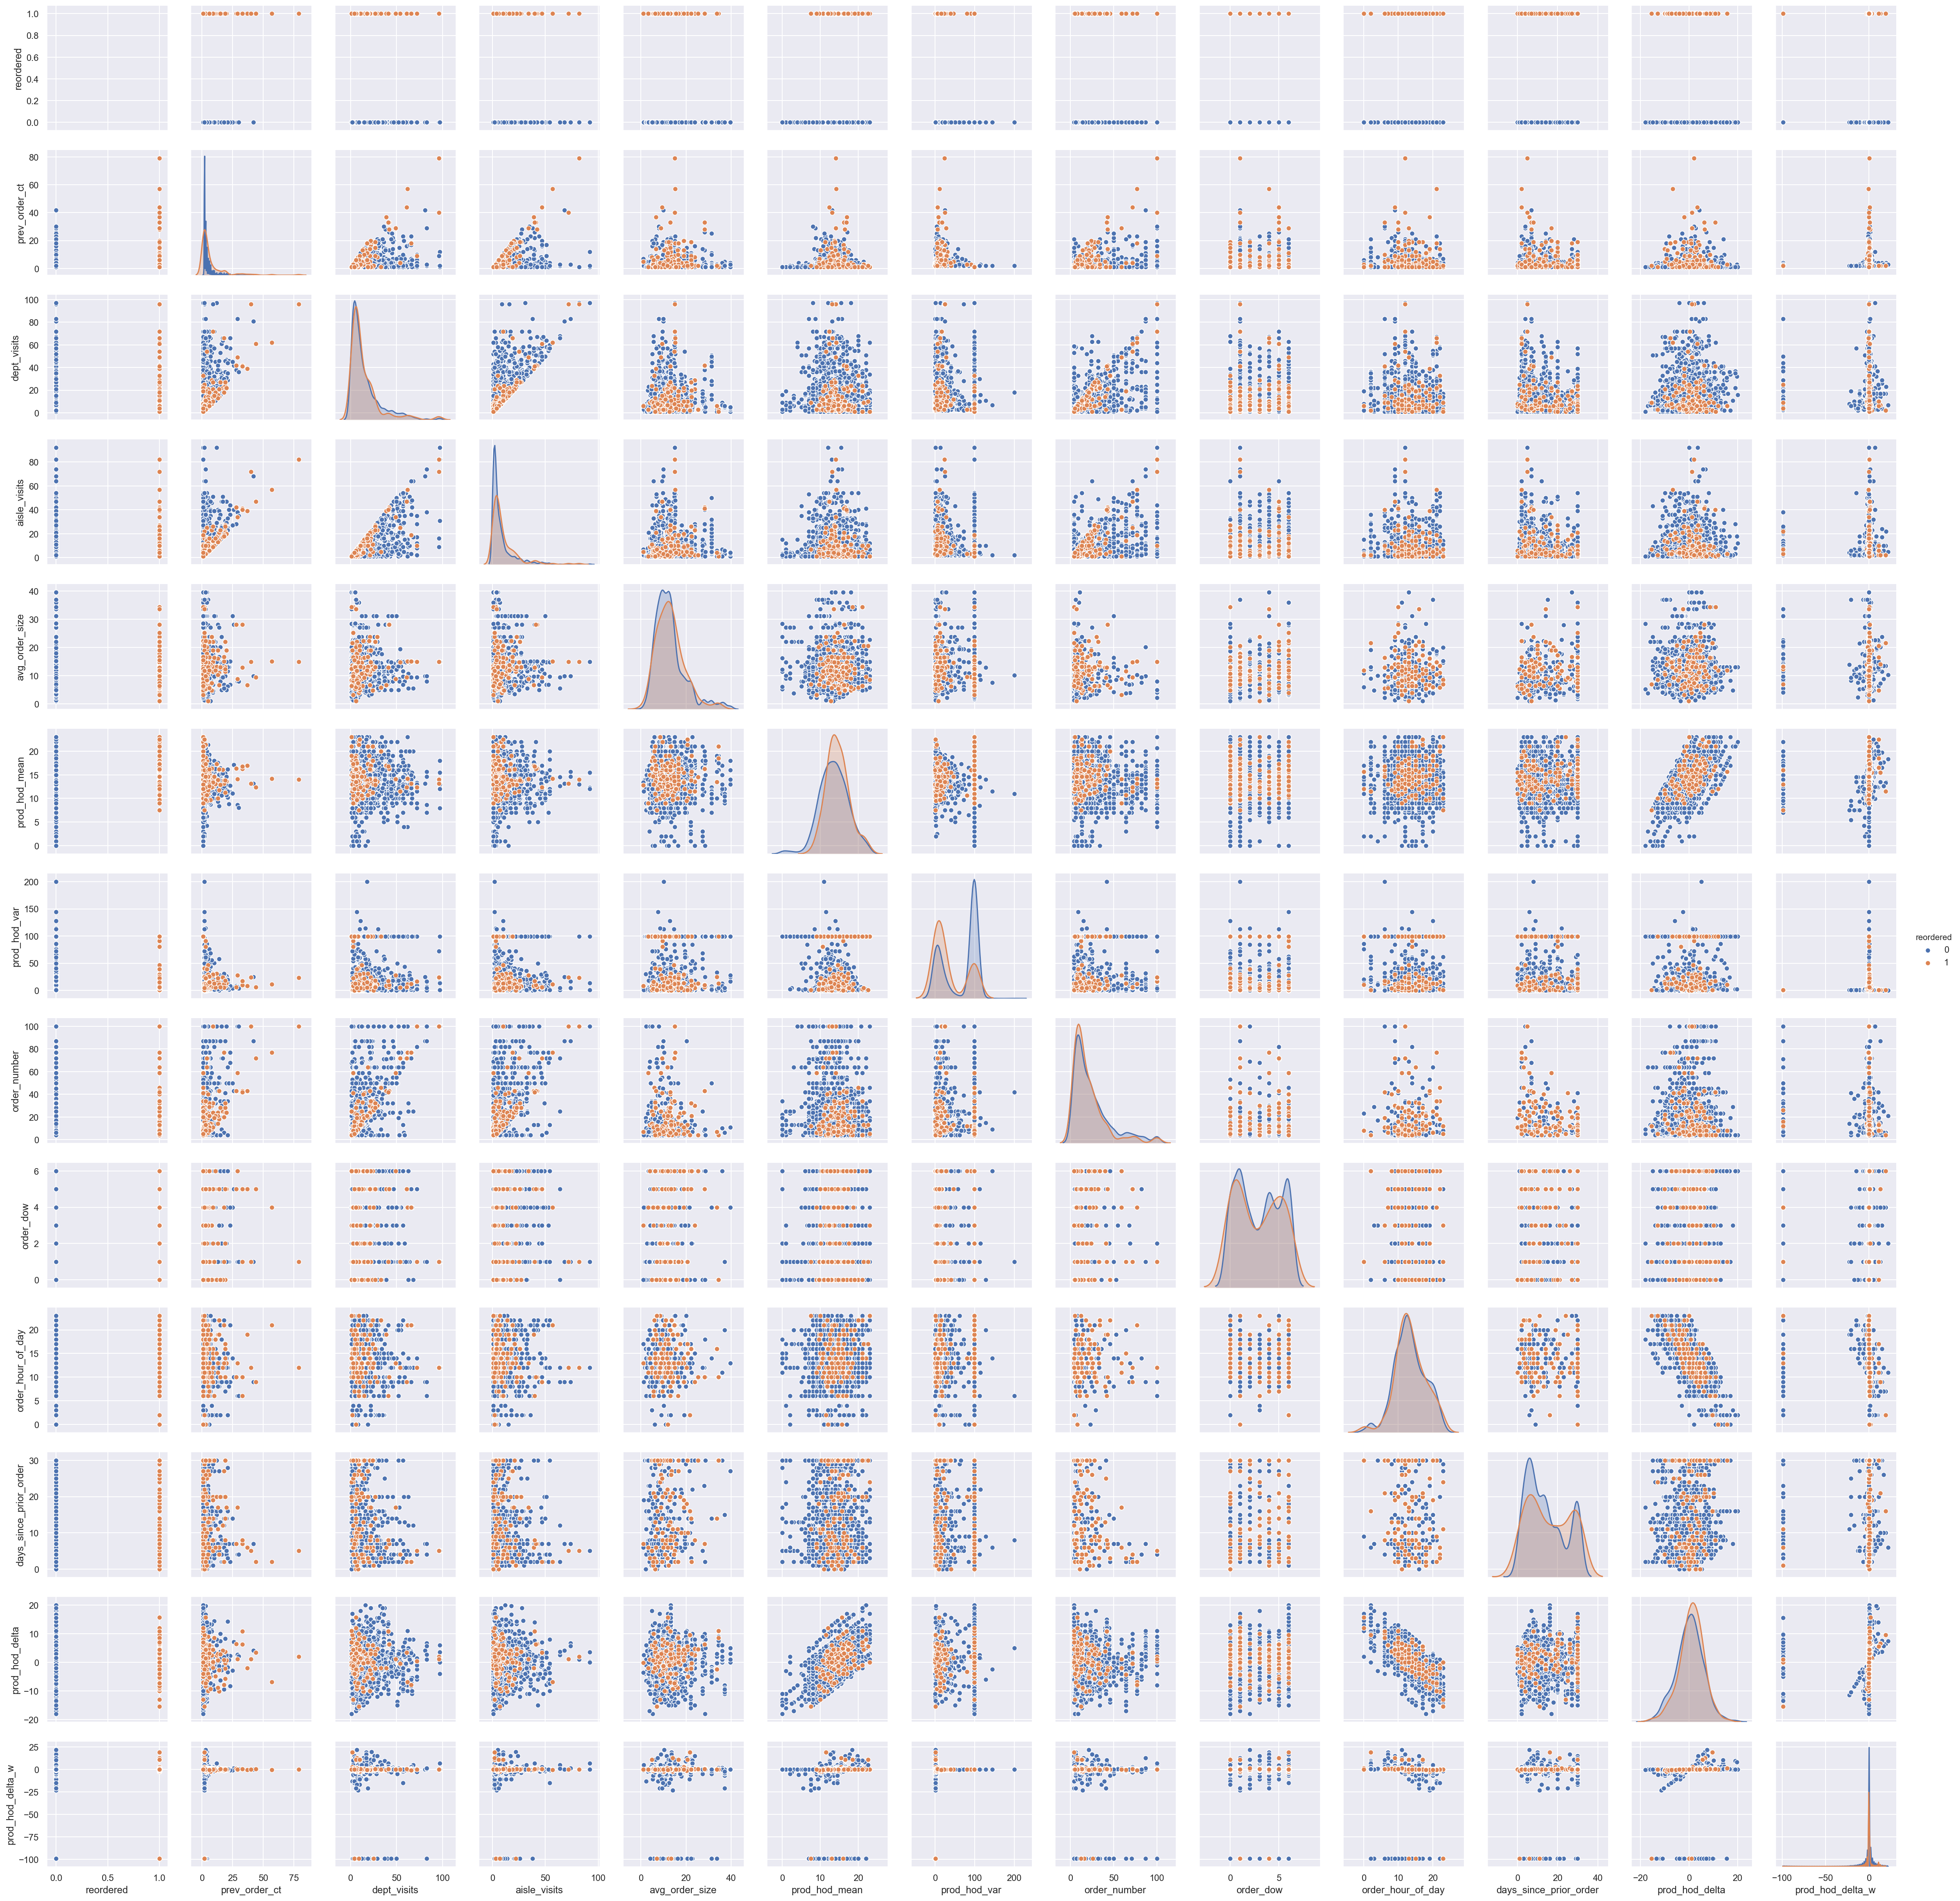

In [571]:
features_and_target = ['reordered', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

sns.pairplot(hue='reordered', data = df_Xy.sample(2000), x_vars=features_and_target, y_vars=features_and_target)

In [462]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id',
            'product_id',
#             'reordered_in_order_id',
            'aisle_id', 'department_id',
            'prev_order_ct', 'dept_visits', 'aisle_visits', 'avg_order_size']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
#     ['RF with 2000 est, depth 2', RandomForestClassifier(n_estimators=2000, max_depth=2)],
#     ['RF with 2000 est, depth 3', RandomForestClassifier(n_estimators=2000, max_depth=3)],
    ['XGB with Defaults', xgb.XGBClassifier(n_estimators=3000, verbosity=1)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 1 Models Against Baseline
features:
['user_id', 'product_id', 'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits', 'aisle_visits', 'avg_order_size']
.............................................

__________ BASELINE __________
Train Set precision=0.06546357102228657
Validation Set precision=0.0626648053358151
-------

__________ XGB with Defaults __________
Train Set precision=0.9695652173913043
Validation Set precision=0.41739130434782606
-------



In [56]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id',
       'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
    ['RF with 1000 est, depth 8', RandomForestClassifier(n_estimators=500, max_depth=8)],
    ['XGB with 1000 est, depth 4', xgb.XGBClassifier(n_estimators=500, max_depth=4, verbosity=1)],
    ['XGB with 1000 est, depth 6', xgb.XGBClassifier(n_estimators=500, max_depth=6, verbosity=1)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 3 Models Against Baseline
features:
['user_id', 'product_id', 'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits', 'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']
.............................................

__________ BASELINE __________
Train Set precision=0.06463622731268422 and f1=0.12142406139200546
Validation Set precision=0.06421591437878083 and f1=0.12068211630957586
-------

__________ RF with 1000 est, depth 8 __________
Train Set precision=1.0 and f1=0.0392156862745098
Validation Set precision=0.5 and f1=0.009569377990430622
-------

__________ XGB with 1000 est, depth 4 __________
Train Set precision=0.9663865546218487 and f1=0.5330243337195828
Validation Set precision=0.5096153846153846 and f1=0.20463320463320467
-------

__________ XGB with 1000 est, depth 6 __________
Train Set precision=0.9990049751243781 and f1=0.8904656

In [578]:
########################################
##          MODEL RUN TEMPLATE        ##
########################################

df = df_Xy
target = 'reordered'
features = ['user_id', 'product_id',
       'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits',
       'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']

X_train, X_val, y_train, y_val = train_val_test_split(df, features, target, train_and_val=True)

estimators = [
#     ['RF with 2000 est, depth 2', RandomForestClassifier(n_estimators=2000, max_depth=2)],
#     ['RF with 2000 est, depth 3', RandomForestClassifier(n_estimators=2000, max_depth=3)],
    ['Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=10000)]
    ]

CheckModelPerformance(estimators, X_train, X_val, y_train, y_val, print_baseline=True)

Testing 1 Models Against Baseline
features:
['user_id', 'product_id', 'aisle_id', 'department_id', 'prev_order_ct', 'dept_visits', 'aisle_visits', 'avg_order_size', 'prod_hod_mean', 'prod_hod_var', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'prod_hod_delta', 'prod_hod_delta_w']
.............................................

__________ BASELINE __________
Train Set precision=0.0649464812037851
Validation Set precision=0.0632852489530014
-------

__________ Logistic Regression __________
Train Set precision=0.4375
Validation Set precision=0.36363636363636365
-------



In [22]:
boost = estimators[0][1]

NameError: name 'estimators' is not defined

In [464]:
y_preds = boost.predict(X_val)

In [471]:
sum(y_val.values)

404

In [468]:
tn, fp, fn, tp = confusion_matrix(y_val, y_preds).ravel()
tn, fp

(5976, 67)

In [469]:
tp

48

In [472]:
fn

356

In [466]:
confusion_matrix(y_val, y_preds)

array([[5976,   67],
       [ 356,   48]])

# Flask App Integration

### User Scope - Order Predictions

In [5]:
_ = pd.merge(pd.merge(df_order_prods__train, df_prod_dir), df_orders_log)
_ = _[['user_id','product_id','product_name','add_to_cart_order']]
sample_user_orders = _[_.user_id < 10]

In [6]:
sample_user_orders.sort_values('add_to_cart_order')

user_id  product_id                                 product_name  \
1626        5       15349                     Organic Raw Agave Nectar   
588         8       15937                                      Shallot   
1219        1         196                                         Soda   
2814        7       12053            Panama Peach Antioxidant Infusion   
1053        9       27555             Organic Dried Granny Apple Chips   
...       ...         ...                                          ...   
265         2       48821                          Pistachio Ice Cream   
266         2       11913                           Shelled Pistachios   
248         2       45645          Dark Chocolate Nuts & Sea Salt Bars   
267         2        1757            Organic Cashew Carrot Ginger Soup   
268         2       21329  Organic Hearty Split Pea & Uncured Ham Soup   

      add_to_cart_order  
1626                  1  
588                   1  
1219                  1  
2814                  1  
1053                  1  
...                 ...  
265                  27  
266                  28  
248                  29  
267                  30  
268                  31  

[100 rows x 4 columns]

In [7]:
import pickle

In [8]:
with open('../flask/data/sample_user_orders.pkl', 'wb') as file:
    pickle.dump(sample_user_orders, file)